# Assignment \#4 : Line Broadening

Kaimi Kahihikolo

Due: 22 February 2019

In [82]:
import numpy as np
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
plt.style.use('seaborn')

___
## (1) Natural Broadening

1. Calculate a Lorentz profile for an absorption line corresponding to a transition with level lifetimes $\Delta t = 10^{-8}$s, and frequency $\nu_0$ equivalent to a wavelength of $5000 A^{\circ}$. Make your calculation for an array of 100 frequencies centered at $\nu_0$ (choose the range of frequencies wisely). 
1. Next, calculate and plot the Lorentz profile as a function of wavelength. Choose plot limits that will allow to appreciate the peak and wings of the profile. 
1. Estimate on your plot the FWHM of the profile in $A^{\circ}$. It should agree with $\Gamma /2\pi$ transformed into $A^{\circ}$.

In [83]:
lifetime = 1e-8 *u.s
nu0 = (const. c / (5000 * u.AA)).to('Hz')

### (1.1)

In [84]:
def lorentz(nus, nu0=nu0, time=lifetime):
    Gamma = 1./time
    term1 = Gamma
    term2 = (4*np.pi**2)*(nus-nu0)**2
    term3 = (Gamma/(2.))**2
    
    return term1 * 1./(term2 + term3)

In [123]:
nus = np.arange(nu0.value - 1e8, nu0.value + 1e8, 100) * u.Hz
profile = lorentz(nus, nu0, lifetime)

### (1.2)

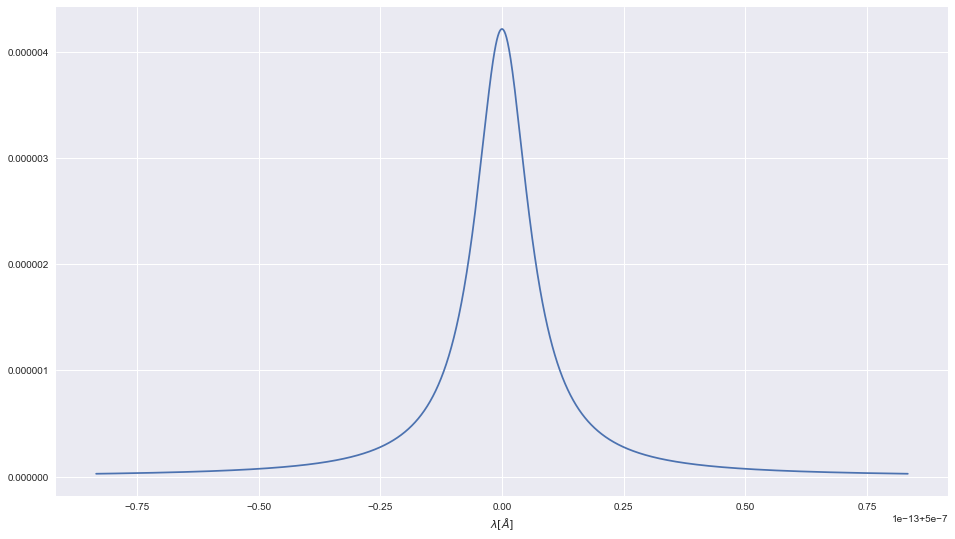

In [133]:
fig = plt.figure(figsize=(16,9))
plt.plot(const.c / nus, profile.value/ np.trapz(profile.value))

plt.xlabel('$\lambda [\AA]$')
plt.savefig('lorentz.png', dpi=300, bbox_inches='tight')

### (1.3)

In [131]:
def fwhm(x, y, k=3):
    from scipy.interpolate import splrep, sproot, splev
    """
    Determine full-with-half-maximum of a peaked set of points, x and y. The function
    uses a spline interpolation of order k.
    """

    half_max = np.amax(y)/2.0
    s = splrep(x, y - half_max, k=k)
    roots = sproot(s)
    
    return abs(roots[1] - roots[0])

fwhm_lorentz = (fwhm(nus.value, profile.value))*u.Hz
print(f"FWHM [from curve] = {(const.c / fwhm_lorentz).decompose().round(3)}")

print(f"Damping Constant [Gamma/2pi] = {(const.c /((1./ lifetime) / (2*np.pi))).round(3)}")

FWHM [from curve] = 18.837 m
Damping Constant [Gamma/2pi] = 18.837 m


___
## (2) Doppler Broadening

1. Calculate $V_{th}$ and $\Delta \lambda_D$ for MgII line at 4481 $A^{\circ}$, at a temperature of 10000 K. Calculate a Guassian profile and plot it. $$\exp\left(-\frac{(\lambda-\lambda_0)^2}{\Delta\lambda_D^2}\right)$$
1. Calculate the intensity of the Gaussian profile at a wavelength $\lambda = \lambda_0 + \Delta\lambda_D$.
- Now compare with the Lorentz profile calculated in Section
1.
1. At what wavelength, measured from λ0, will the Lorentz profile become higher than the Doppler profile?
1. Make a plot showing both profiles (it may be
more illustrative to plot the log of the intensity as a function of wavelength)


### (2.1)

### (2.2)

### (2.3)

### (2.4)

### (2.5)

___
## (2) Rotation

1. Calculate the escape velocities for main sequence stars of spectral types O, B, A, F and G. The stellar parameters may be taken from the Hertzsprung Russell diagrams shown in the first Power-Point, or from any edition of Allen’s Astrophysical Quantities. 
1. Make a table with your input parameters and results. Which stars have the highest escape velocities? 
1. Calculate the maximum rotational broadening (total width of line profile), in $A^{\circ}$, that we can expect to find for a B-type star. Assume a non-Hydrogen spectral line at 5000 $A^{\circ}$. Why did I specify that it cannot be a H-line?

### (2.1)

### (2.2)

### (2.3)